Project Credit Risk
==

**Deadline : 28/02/2022**

***
DETAIL DU PLAN DU PROJET
==
*****

**Objectif** : Le but de cette étude est de construire un modèle basé sur cet échantillon permettant de construire la nouvelle grille de probabilité de défaut.

<u><h4>Decrir le jeu de données</h4></u>
- [X] construction d'un dictionnaire de données

<u><h4>Analyse de la variable cible</h4></u><br>

- [X] Identifier la variable cible
- [X] Examen de la distribution de la variable cible

<u><h4>Exploration de base des données</h4></u>

- [X] Statistique descriptif des données
- [X] Analyse visuelle exploratoire des données (Histogramme et Barcharts)
- [X] Sélection des caractéristiques en fonction de la distribution des données
- [X] Traitement des valeurs aberrantes
- [X] Traitement des valeurs manquantes

<u><h4>Construction de profile de risque (defaut)</h4></u>
- [X] Statistique croisé
- [X] Analyse statistique des corrélations (Sélection des caractéristiques)

<u><h4>Preparation modélisation</h4></u>
- [X] Conversion des données en données numériques pour le ML
- [X] Échantillonnage et validation croisée K-fold pour identification de meillleur paramettre du modèle

<u><h4>Modelisation et construction de classe de defaut</h4></u>

- [X] algo de DecisionTreeClassifier
- [X] modele de LinearDiscriminantAnalysis
- [X] modele de LogisticRegression
- [X] algo de KNN
- [X] algo de GradientBoostingClassifier
- [X] algo de RandomForestClassifier

<u><h4>Construction de classe homogene de risque</h4></u>
- [X] à realiser pour chaque modele

<u><h4>Utiles</h4></u>
- [X] methode de selection de varaible modrene :  Methode LASSO,RFE ou SequentialFeatureSelector

<u><h4>Conclusion</h4></u>

[**remarque**](https://zhuanlan.zhihu.com/p/255105477) : <br>

*pour chque algo ici proposer un documentation (description assez exhaustive du fonctionnement de ces algo avec a l'appuis un schema algorithim)* 

resource :
- [x] [source data](http://www.creditriskanalytics.net/datasets-private2.html)

Chargement des bibliothèques
==

In [1212]:
import pandas as pd
import os
# plotting
import matplotlib.pyplot as plt
import seaborn as sns

#modeling
import numpy as np
import scipy as sp
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from scipy.stats import skew
import scorecardpy as sc
import statsmodels.api as sm
from statsmodels.tools import tools
from statsmodels.iolib.summary import Summary
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector, ExhaustiveFeatureSelector
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, precision_recall_curve
from sklearn.metrics import make_scorer, auc, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE


#formating
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")
import time
import re

Chargement des données
==

In [1213]:
#recupperation des données
list_df = [c for c in os.listdir() if c.endswith(".csv")]
list_df

['base_modele_final.csv',
 'final_dataset.csv',
 'mortgage.csv',
 'table_classe.csv',
 'test.csv']

In [1214]:
#chargement des données et affichage
df = pd.read_csv(list_df[2])
print(df.shape)
df.head(5)

(622489, 23)


,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,...,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time
0,1,25,-7,25,113,41303.42,24.498336,9.2,226.29,2.899137,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
1,1,26,-7,25,113,41061.95,24.483867,9.2,225.10,2.151365,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
2,1,27,-7,25,113,40804.42,24.626795,9.2,222.39,2.361722,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
3,1,28,-7,25,113,40483.89,24.735883,9.2,219.67,1.229172,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
4,1,29,-7,25,113,40367.06,24.925476,9.2,217.37,1.692969,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0


Consctruction du dictionnaire de données
--

In [1215]:
#dicionnaire de données

def description(element: str) -> str:

    dictionnaire = {
      "ID": "ID de l’emprunteur",
      "time" : "Periode d’observation",
      "orig_time" : "Periode d'observation à l’origine",
      "first_time" : "Periode de la première observation",
      "mat_time" : "Periode de l’échéance",
      "balance_time" : "Solde impayé au moment de l’observation",
      "LTV_time" : "Ratio prêt/valeur au moment de l’observation (en %)",
      "interest_rate_time" : "Taux d’intérêt au moment de l’observation (en %)",
      "hpi_time": "Indice des prix des logements au moment de l’observation (année de référence = 100)",
      "gdp_time": "Croissance du produit intérieur brut (PIB) au moment de l’observation (en %)",
      "uer_time": "Taux de chômage au moment de l’observation (en %)",
      "REtype_CO_orig_time": "Type immobilier (copropriété = 1, sinon = 0)",
      "REtype_PU_orig_time": "Type de bien immobilier (développement urbain planifié = 1, sinon = 0)",
      "REtype_SF_orig_time": "Type de Maison (unifamiliale = 1, sinon = 0)",
      "investor_orig_time": "Investisseur (emprunteur = 1, sinon = 0)",
      "balance_orig_time": "Solde impayé au moment de l’origine",
      "FICO_orig_time": "Score FICO au moment de l’origination (en %)",
      "LTV_orig_time": "Ratio prêt/valeur à l’origine (en %)",
      "Interest_Rate_orig_time": "Taux d’intérêt à l’origine (en %)",
      "hpi_orig_time": "Indice des prix des logements à de l’origine (annéede base = 100)",
      "default_time": "Observation du défaut au moment de l’observation",
      "payoff_time": "Observation du gain au moment de l’observation",
      "status_time": "Défaut (1), gain (2) et observation hors défaut/non-paiement (0) au moment de l’observation"}

    return dictionnaire[element]

In [1216]:
description("REtype_CO_orig_time")

'Type immobilier (copropriété = 1, sinon = 0)'

Pretraitement de données
==

Gestion des doublons
--

In [1217]:
#trie pour supression de doublons

df.sort_values(by = ['id', 'time'] ,ascending = [True,False],inplace=True)
df.drop_duplicates(subset="id",keep="first",inplace=True)

In [1218]:
#verification
print(df.shape)
df.head(5)

(50000, 23)


,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,...,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time
23,1,48,-7,25,113,29087.21,26.658065,9.200,146.45,2.715903,...,1,0,45000.0,715,69.4,9.200,87.03,1,0,1
25,2,26,18,25,138,105654.77,65.469851,7.680,225.10,2.151365,...,1,0,107200.0,558,80.0,7.680,186.91,0,1,2
30,3,29,-6,25,114,44378.60,31.459735,11.375,217.37,1.692969,...,1,0,48600.0,680,83.6,8.750,89.58,0,1,2
65,4,60,-2,25,119,52686.35,34.898842,10.500,189.82,2.836358,...,1,0,63750.0,587,81.8,10.500,97.99,0,0,0
68,5,27,18,25,138,52100.71,66.346343,9.155,222.39,2.361722,...,1,0,52800.0,527,80.0,9.155,186.91,0,1,2


Gestion des données manquantes
--

In [1219]:
# identification des données manquantes

class Missing(object):

    """
    ---------
    Attributs
    ---------
    data : Jeu de données -> DataFrame  
    --------
    Méthodes
    --------
    stat() :
        Fournit les statisques sur les données manquantes.

    plot():
        Fournit un graphique permettant de visualiser graphiquement 
        les données manquantes dans la base de données
    """  

    def __init__(self,data):

        self.data = data

    def stat(self,):

        """
        Cette fournit les statisques sur les données manquantes.
        -------------
        Paramètre : 
        - data : jeu de données -> DataFrame
    
        Sortie : 
        - Statistique renseignat sur :
            * le nombre de donnée manquantes de chaque variable
            * le % de données manquantes de chaque variable
            * le type de données de chaque variable
            * le nombre de données disponible de chaque variable
        -------------
        """

        d1 = self.data.isna().sum().to_frame()
        d2 = ((self.data.isna().sum() / self.data.shape[0])*100).to_frame().round(2).astype('string')+"%"
        d3 = self.data.dtypes.to_frame()
        d4 = self.data.count()
        df_missing = pd.concat([d1,d2,d3,d4],axis = 1)
        df_missing.columns = ['missing value','% of missing value','data dtypes',"count"]
        print('='*76)
        print("Statistique données manquante",'{:>45}'.format("obs: "+str(df_missing.shape[0])))
        print('-'*76)
        print(df_missing.sort_values(by='missing value',ascending=False))
        print("="*76)


    def plot(self,):

        """
        Cette fournit un graphique permettant de visualiser graphiquement 
        les données manquantes dans la base de données
        -------------
        Paramètre : 
        - data : jeu de données -> DataFrame
    
        Sortie : 
        - graphique : heatmap()
        -------------
        """
        plt.figure(figsize = (18,9))
        sns.heatmap(self.data.isna());


In [1220]:
#filtrage de données NaN
missing = Missing(df)
missing.stat()

Statistique données manquante                                       obs: 23
----------------------------------------------------------------------------
                         missing value % of missing value data dtypes  count
LTV_time                            18              0.04%     float64  49982
id                                   0               0.0%       int64  50000
REtype_PU_orig_time                  0               0.0%       int64  50000
payoff_time                          0               0.0%       int64  50000
default_time                         0               0.0%       int64  50000
hpi_orig_time                        0               0.0%     float64  50000
Interest_Rate_orig_time              0               0.0%     float64  50000
LTV_orig_time                        0               0.0%     float64  50000
FICO_orig_time                       0               0.0%       int64  50000
balance_orig_time                    0               0.0%     float64  50000


### traitemnet des données manquantes de la variable `LTV_time`

In [1221]:
description("LTV_time")

'Ratio prêt/valeur au moment de l’observation (en %)'

In [1222]:
#stat desc pour verifier l'homogeneité de la dist de la varable (ici median et moy meme valeur et std<mean la variable est plutot stable)
df["LTV_time"].describe()

count    49982.000000
mean        79.311836
std         25.132516
min          0.000000
25%         64.116470
50%         78.718905
75%         95.745375
max        616.985143
Name: LTV_time, dtype: float64

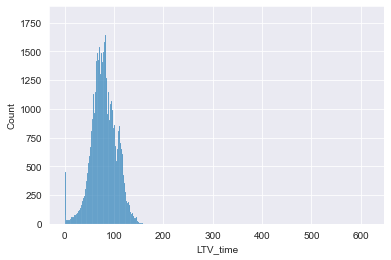

In [1223]:
sns.histplot(df["LTV_time"]);

**Remarque** : la variable `LTV_time` semble ne pas dispersé on peu donc opter pour une imputation par la moyenne ou par la mediane 

In [1224]:
#impuration par la moyenne
df["LTV_time"].fillna(df["LTV_time"].mean(),inplace = True) 

Construction de varaible
--

Etant donner le fait que la plus part de variable renseigne sur moment different (etat d'origine et etat actuelle) il nous a paru natuelle de construit de nouvelle variable qui visait à monter l'impact d'une hausse ou d'une baisse de ses variable sur la variable cible.

In [1225]:
# l'idée etant de fournit une interpretation intutive et coherente tout en reduisant le numbre de variable

#calcul de LVT
df["LTV"] = df["LTV_time"] - df["LTV_orig_time"] 
#si lvt > 0 -> baisse de la valeur du bien 
#si lvt < 0 -> aug de la valeur du bien

#calcul de interest_rate
df["interest_rate"] = df["interest_rate_time"] - df["Interest_Rate_orig_time"]
#si interest_rate < 0 -> baisse du taux
#si interest_rate > 0 -> aug du taux

#calcul de hpi
df["HPI"] = df["hpi_time"] - df["hpi_orig_time"]
#si HPI < 0 -> baisse du hpi
#si HPI > 0 -> aug du hpi

#calcul balance
df["balance"] = df["balance_time"] - df["balance_orig_time"]
#si balance < 0 -> baisse du sold impayé
#si balance > 0 -> aug du sold impayé


Analyse de la variable cible
==

In [1226]:
# summary de la varaible cible
endog = df["default_time"]
proportion = (df.groupby(["default_time"]).size())
d1 = (((((df.groupby(["default_time"]).size()) / df.shape[0])*100).round(2)).to_frame("% of count")).astype("string")+"%"
resume = pd.concat([proportion.to_frame("Count"), d1],axis=1)
resume

,Count,% of count
default_time,,
0,34846,69.69%
1,15154,30.31%


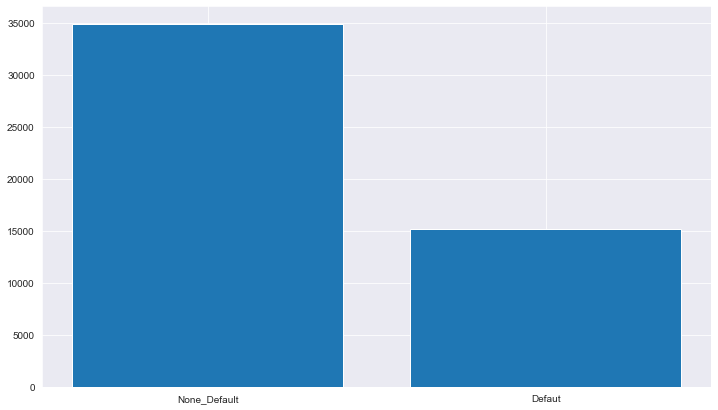

In [1227]:
# representation de la distrubution de la variable cible

cible = proportion.to_frame("count")
cible = cible.reset_index()

plt.figure(figsize=(12,7))
plt.bar(cible["default_time"] ,cible["count"])
plt.xticks(ticks=list(range(2)),labels=["None_Default","Defaut"]);

<h1><u>Analyse exploratoire des données</u></h1>

### identification des variables categorielles et continues

In [1228]:
categorical_variable = list(df.nunique()[df.nunique()<4].index)
continuous_var = list(df.nunique()[df.nunique()>4].index)

In [1229]:
try:
    if "default_time" in categorical_variable or "id" in continuous_var:
        categorical_variable.remove("default_time")
        continuous_var.remove("id")
    else:
        pass
except Exception as e:
    pass

### statistique descriptif

In [1230]:
def statistique(data,var):
    
    a = data[var].describe().T.round(3)[["count","mean","std","min","50%","max"]]
    a["cv"] = a['std'] / a['mean']
    
    return a

In [1231]:
description("REtype_CO_orig_time")

'Type immobilier (copropriété = 1, sinon = 0)'

In [1232]:
# stat varaible continue
statistique(df,continuous_var)

,count,mean,std,min,50%,max,cv
time,50000.0,36.171,13.993,1.000,32.000,60.000,0.386857
orig_time,50000.0,20.388,7.881,-40.000,22.000,60.000,0.386551
first_time,50000.0,24.696,7.898,1.000,25.000,60.000,0.319809
mat_time,50000.0,137.924,17.944,18.000,141.000,229.000,0.130101
balance_time,50000.0,238968.146,203090.539,0.000,183554.525,8688100.840,0.849864
LTV_time,50000.0,79.312,25.128,0.000,78.727,616.985,0.316825
interest_rate_time,50000.0,7.015,2.214,0.000,7.000,37.500,0.315609
hpi_time,50000.0,190.292,26.286,107.830,189.820,226.290,0.138135
gdp_time,50000.0,1.690,1.918,-4.147,2.274,5.132,1.134911
uer_time,50000.0,6.001,1.675,3.800,5.500,10.000,0.279120


Analyse visuelle des variables continues
--

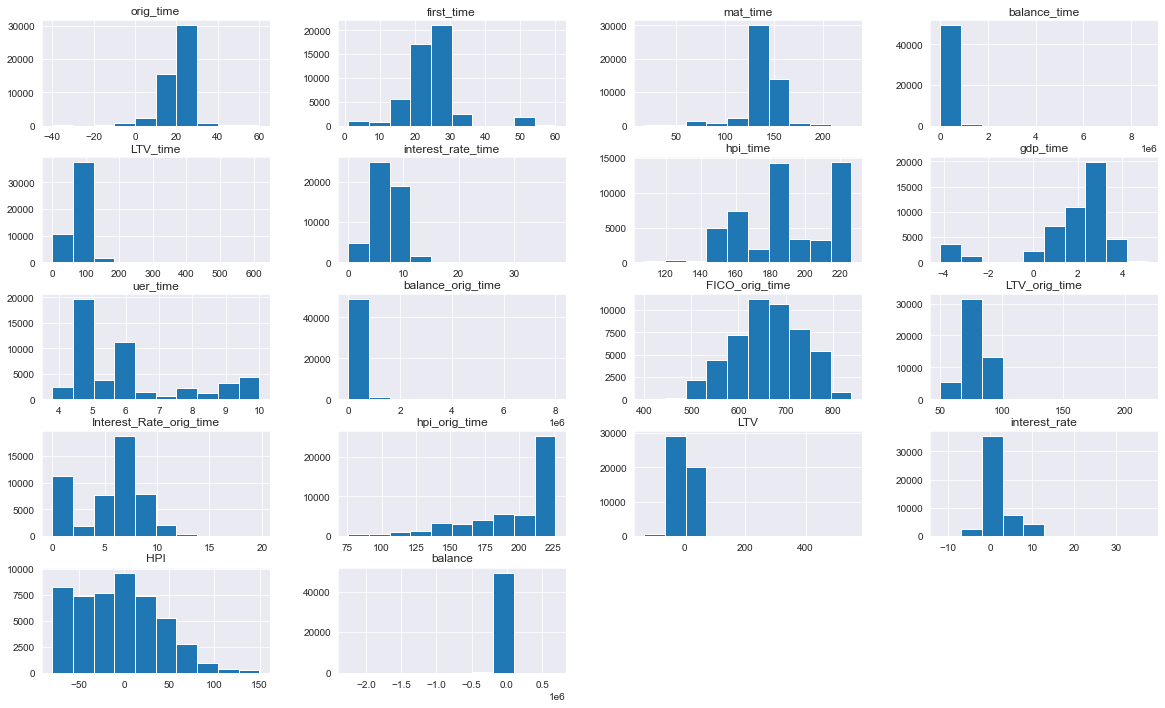

In [1233]:
df.hist(continuous_var[1:], figsize=(20,12));

In [1234]:
def describe(data,var):
    pro = (data.groupby([var]).size())
    d11 = (((((data.groupby([var]).size()) / data.shape[0])*100).round(2)).to_frame("% of count")).astype("string")+"%"
    res = pd.concat([pro.to_frame("Count"), d11],axis=1)
    return res

In [1235]:
# stat varaible categorielle
for c in categorical_variable:
    print(description(c))
    display(describe(df,c))
    print("\n\n")
    

Type immobilier (copropriété = 1, sinon = 0)


,Count,% of count
REtype_CO_orig_time,,
0,46752,93.5%
1,3248,6.5%





Type de bien immobilier (développement urbain planifié = 1, sinon = 0)


,Count,% of count
REtype_PU_orig_time,,
0,44206,88.41%
1,5794,11.59%





Type de Maison (unifamiliale = 1, sinon = 0)


,Count,% of count
REtype_SF_orig_time,,
0,18813,37.63%
1,31187,62.37%





Investisseur (emprunteur = 1, sinon = 0)


,Count,% of count
investor_orig_time,,
0,44080,88.16%
1,5920,11.84%





Observation du gain au moment de l’observation


,Count,% of count
payoff_time,,
0,23418,46.84%
1,26582,53.16%





Défaut (1), gain (2) et observation hors défaut/non-paiement (0) au moment de l’observation


,Count,% of count
status_time,,
0,8264,16.53%
1,15154,30.31%
2,26582,53.16%


Analyse visuelle des variables categorielle
--

In [1236]:
def BarCharts(Data, categorical_columns):
    
    fig, subPlot=plt.subplots(nrows=1, ncols=len(categorical_columns), figsize=(30,6))
    fig.suptitle('Bar charts of: '+ str(categorical_columns))

    for colName, plotNumber in zip(categorical_columns, range(len(categorical_columns))):
        Data.groupby(colName).size().plot(kind='bar',ax=subPlot[plotNumber])

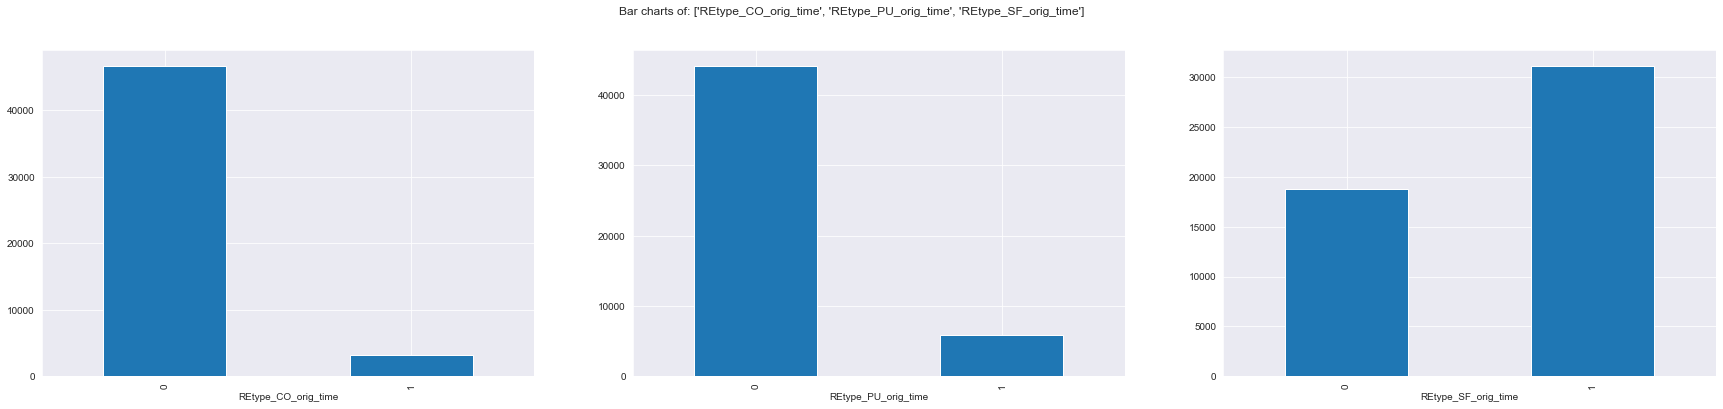

In [1237]:
BarCharts(df,categorical_variable[:3])

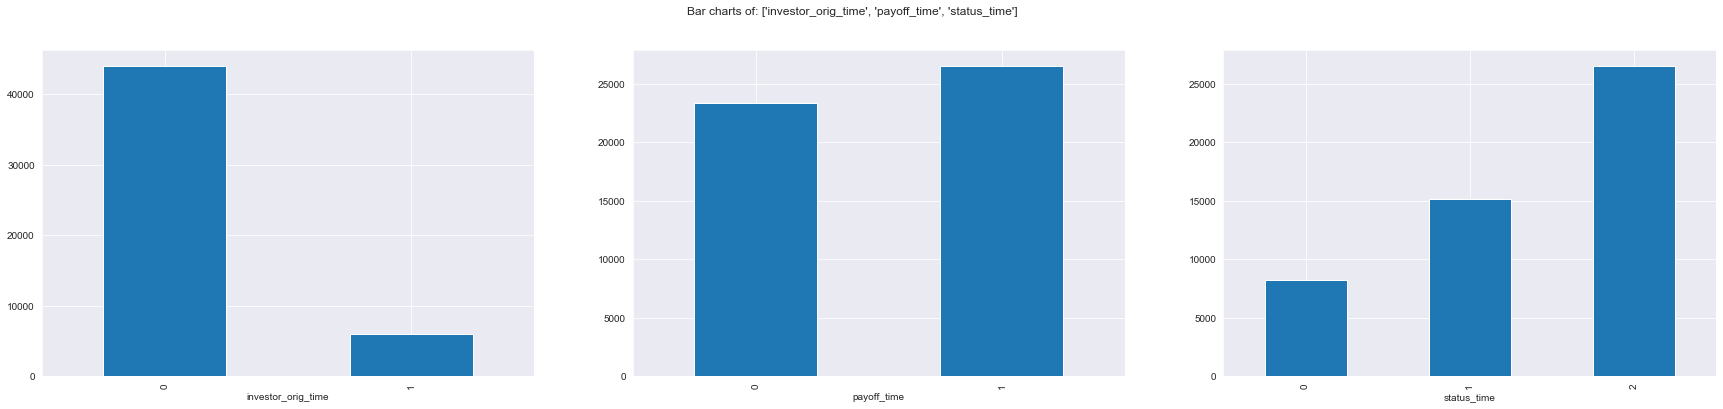

In [1238]:
BarCharts(df,categorical_variable[3:])

### construction de profile de risque et statistique croiser avec la variable cible ``default_time``

In [1239]:
class RiskProfil(object):
    
    def __init__(self,data):

        self.data = data

    def continuous_profile(self,target,continous):
    
        z_continous = (self.data.groupby(target)[continous].mean().T).round(3)
        z_continous.columns = ["Default","None default"]
        z_continous = z_continous[:]
    
        return z_continous
      
    def Crosstable(self,target,variable):
        
        crosstab = ((pd.crosstab(index=self.data[target],columns=self.data[variable],margins="all") / len(df[variable]))*100).round(2).astype("string")+"%"
        return crosstab.loc[0:1]


In [1240]:
risk = RiskProfil(df)

In [1241]:
#qualitative variables cross stat

for c in categorical_variable:
    print(description(c))
    display(risk.Crosstable("default_time",c))
    print("\n\n") #moyenne de chaque varaible pour chaque classe de defaut

Type immobilier (copropriété = 1, sinon = 0)


REtype_CO_orig_time,0,1,All
default_time,,,
0,65.24%,4.45%,69.69%
1,28.26%,2.04%,30.31%





Type de bien immobilier (développement urbain planifié = 1, sinon = 0)


REtype_PU_orig_time,0,1,All
default_time,,,
0,61.81%,7.88%,69.69%
1,26.6%,3.71%,30.31%





Type de Maison (unifamiliale = 1, sinon = 0)


REtype_SF_orig_time,0,1,All
default_time,,,
0,26.2%,43.49%,69.69%
1,11.42%,18.88%,30.31%





Investisseur (emprunteur = 1, sinon = 0)


investor_orig_time,0,1,All
default_time,,,
0,61.77%,7.92%,69.69%
1,26.39%,3.92%,30.31%





Observation du gain au moment de l’observation


payoff_time,0,1,All
default_time,,,
0,16.53%,53.16%,69.69%
1,30.31%,0.0%,30.31%





Défaut (1), gain (2) et observation hors défaut/non-paiement (0) au moment de l’observation


status_time,0,1,2,All
default_time,,,,
0,16.53%,0.0%,53.16%,69.69%
1,0.0%,30.31%,0.0%,30.31%


In [1242]:
#continuous varaiables cross stat
risk.continuous_profile("default_time", continuous_var) #moyenne de chaque varaible pour chaque classe de defaut

,Default,None default
time,36.375,35.702
orig_time,19.297,22.897
first_time,24.065,26.147
mat_time,135.780,142.853
balance_time,233085.461,252495.139
LTV_time,71.646,96.939
interest_rate_time,6.783,7.547
hpi_time,196.214,176.675
gdp_time,2.185,0.553
uer_time,5.630,6.854


selection des variables 
==

Selection Automatique de variable
==

### construction du selecteur

In [1243]:
def Variable_selection(selector, estimateur, X_train, y_train, X_test, Forward = False, metric = "accuracy", 
                 smote = False, cv = 5):  
 
    """
    Cette fonction affiche pour chaque selector et estimateur, le nombre de variables
    selectionnés, les variables selectionnées.
    Si le selector est la RFE ou ExhaustiveFeatureSelector, la fonction affiche le score obtenu après la sélection.
    
    Paramètres :
    ------
    selector : Une méthode de sélection de variables dans {"RFE", "SequentialFeatureSelector", "ExhaustiveFeatureSelector"}
                
    estimateur : Tout algorithme de classification type sklearn 
    {LogisticRegression(),DecisionTreeClassifier(),LinearDiscriminantAnalysis(),KNeighborsClassifier(),RandomForestClassifier(), GradientBoostingClassifier(), VotingClassifier(), StackingClassifier()},
    
    Forward : bool (default: True)
            Forward selection si True,
    
    print_estimateur : bool (default: False)
                    Affiche le nom de l'estimateur utilisé
    
    Remarque :
    ----------
    Nous recommandons de ne pas utiliser une technique de Validation croisée avec la selection ExhaustiveFeatureSelector.
    En effet elle l'inclut déjà.
    
    Examples
    --------
    >>>from sklearn.linear_model import LogisticRegression
    >>>from sklearn.feature_selection import RFE
    
    selection(RFE, LogisticRegression(), print_estimateur = True)
    """
    import time
    import re
    
    if smote == True:


        smote = SMOTE(random_state=0 ,k_neighbors=15)
        X_train, y_train = smote.fit_resample(X_train, y_train)

    if selector == RFE:

        a = re.findall(r"\w+", str(selector))
        t1 = time.time()
        nov_list=np.arange(1, X_train.shape[1]+1)            
        high_score=0
        nov=0           
        score_list =[]
        for n in range(len(nov_list)):
            model = estimateur
            b = re.findall(r"[A-Za-z0-9\(\)\_\=\,]+", str(model))
            sel = selector(model,n_features_to_select = nov_list[n])
            X_train_sel = sel.fit_transform(X_train, y_train)
            X_test_sel = sel.transform(X_test)
            model.fit(X_train_sel,y_train)
            scores = cross_val_score(model, X_train_sel, y_train, scoring = metric, cv = cv)
            score = np.mean(scores)
            score_list.append(score)
            if(score>high_score):
                high_score = score
                nov = nov_list[n]
        t2 = time.time() - t1
        temp = pd.Series(sel.support_,index = X_train.columns)
        variables = temp[temp==True].index

    elif selector == SequentialFeatureSelector:
        t1 = time.time()
        a = re.findall(r"\w+", str(selector))
        model = estimateur
        b = re.findall(r"[A-Za-z0-9\(\)\_\=\,]+", str(model))
        sfs = SequentialFeatureSelector(model, k_features = "best", forward = Forward, scoring = metric, cv = cv )
        sfs.fit(X_train, y_train)
        variables = list(sfs.k_feature_names_)
        t2 = time.time() - t1
        high_score = sfs.k_score_

    elif selector == ExhaustiveFeatureSelector:
        a = re.findall(r"\w+", str(selector))
        t1 = time.time()
        model = estimateur
        b = re.findall(r"[A-Za-z0-9\(\)\_\=\,]+", str(model))
        efs = ExhaustiveFeatureSelector(model, scoring = metric, min_features = 7, max_features = 11, cv = cv)
        efs.fit(X_train, y_train)
        variables = X_train.columns[list(efs.best_idx_)]
        high_score = efs.best_score_
        t2 = time.time() - t1

    all_scores_dict = {"Selector" : a[-1], "Estimateur" : b[0], "Score" : high_score, "N_Variables": len(variables),"Variables" :list(variables), "Duree(s)" : t2 }    

    return all_scores_dict

In [1244]:
def Variable_selection_table(selectors, algos, X_train, y_train, X_test,
                             Forward = False, metric = "accuracy", smote = False, cv = 5):
    """
    docstring à faire
    """
    dictionnaire = {"Selector" : [], "Estimateur" : [], "Score" : [], "N_Variables": [], "Duree(s)" : [], "Variables" : []}

    for algo in algos:
        for selector in selectors :
            all_scores_dict = Variable_selection(selector, algo, X_train, y_train, X_test,  Forward = True, metric=metric, smote = smote)
            dictionnaire["Selector"].append(all_scores_dict["Selector"])
            dictionnaire["Estimateur"].append(all_scores_dict["Estimateur"])
            dictionnaire["Score"].append(all_scores_dict["Score"])
            dictionnaire["N_Variables"].append(all_scores_dict["N_Variables"])
            dictionnaire["Variables"].append(all_scores_dict["Variables"])
            dictionnaire["Duree(s)"].append(all_scores_dict["Duree(s)"])
            
    recap  = pd.DataFrame(dictionnaire)
    recap.sort_values(by=["Score"], inplace=True, ascending=False)
    
    return recap

In [1248]:
# Création de couple target - features dans le train  et test set
classe = sc.woebin(df, y="default_time", positive=1, method="chimerge",bin_num_limit=12)
train, test = train_test_split(df, test_size = 0.2, random_state = 42)
train_woe = sc.woebin_ply(train, classe)
test_woe = sc.woebin_ply(test, classe)
y_train = train_woe["default_time"]
X_train = train_woe.drop(["default_time"], axis =1)
y_test = test_woe["default_time"]
X_test = test_woe.drop(["default_time"], axis =1)

[INFO] creating woe binning ...
Binning on 50000 rows and 27 columns in 00:01:31
[INFO] converting into woe values ...
Woe transformating on 40000 rows and 26 columns in 00:00:11
[INFO] converting into woe values ...


In [1249]:
try:
    selectors = [RFE,SequentialFeatureSelector] #ExhaustiveFeatureSelector]
    algos = [LogisticRegression()]                   #[LogisticRegression(),GradientBoostingClassifier()]
    tables = Variable_selection_table(selectors, algos, X_train, y_train, X_test, metric = "roc_auc", smote = True)
    tables
except Exception as e:
    print(e.args[0])

In [1250]:
tables

,Selector,Estimateur,Score,N_Variables,Duree(s),Variables
1,SequentialFeatureSelector,LogisticRegression(),0.880785,12,530.928122,"[HPI_woe, uer_time_woe, time_woe, balance_woe,..."
0,RFE,LogisticRegression(),0.879310,26,443.256613,"[orig_time_woe, REtype_PU_orig_time_woe, HPI_w..."


Selection Statistique et intuitive des varaibles
==

enquête préliminaire sur la relation entre les caractéristiques
--


In [1251]:
# filtre pour identifier les varaible correler en fonction d'un seuil fixé

def Get_correlate_variable(corr_matrix, corr_threshold):
    """
        Cette fonction fournit un table avec les varaibles correlé significativement.
        -------------
        Paramètre : 
        - corr_matrix : matrice de correlation -> DataFrame
        - corr_threshold : seuil de significativité de correlation -> float
    
        Sortie : 
        - table resumant les differentes variable correlé et leur niveau de correlation -> DataFrame
        -------------
    """
    
    
    correlate_variable = pd.DataFrame(corr_matrix[corr_matrix>corr_threshold].stack().reset_index()) #construction de la table contenant les varaibles avec correlations significative
    correlate_variable.rename({'level_0':'feature_x', 'level_1':'feature_y', 0:'corr'}, axis=1, inplace=True) 
    correlate_variable = correlate_variable[correlate_variable.feature_x != correlate_variable.feature_y] #on recupere les variable differente par ligne
    correlate_variable['feature_pair_key'] = correlate_variable.loc[:,['feature_x', 'feature_y']].apply(lambda r:'#'.join(np.sort(r.values)), axis=1)
    correlate_variable.drop_duplicates(subset=['feature_pair_key'],inplace=True) # suppression des doublons
    correlate_variable.drop(['feature_pair_key'], axis=1, inplace=True)
    return correlate_variable

d = Get_correlate_variable(df.corr(),0.45)

In [1252]:
d.head()

,feature_x,feature_y,corr
2,time,first_time,0.554557
4,orig_time,first_time,0.608733
5,orig_time,mat_time,0.579452
6,orig_time,LTV_time,0.558088
7,orig_time,hpi_orig_time,0.849410


In [1253]:
# get correlate variable list to drop
liste = ["first_time","balance_time","LTV_time","hpi_orig_time"]
drop = set()
for z,x in zip(d["feature_x"],d["feature_y"]):
    if z not in liste:
        drop.add(z)
    if x not in liste:
        drop.add(x)
drop = list(drop)

Intuition graphique
--

In [1254]:
# selection 

def GraphicalAnalysis(data,categorical_target,continuous_columns):

    """
    -----------------------------------------------------------------------------------------
    Cette fonction propose une visulisation la correlation entre l'ensemble 
    des variables explicatives continues et la variable cible categorielle.
    -----------------------------------------------------------------------------------------

    Paramètre : 
    ___________

    - data : Jeu d données -> DataFrame 
    - categorical_target : variable cible -> str (chain de caractère)
    - continuous_columns : ensemble des variable continue -> list()

    Sortie : 
    ______

    - graphique  -> Boxplot()
    """

    fig, PlotCanvas=plt.subplots(nrows=1, ncols=len(continuous_columns), figsize=(18,5))
    for PredictorCol , i in zip(continuous_columns, range(len(continuous_columns))):
        data.boxplot(column=PredictorCol, by=categorical_target, figsize=(20,5), vert=True, ax=PlotCanvas[i])

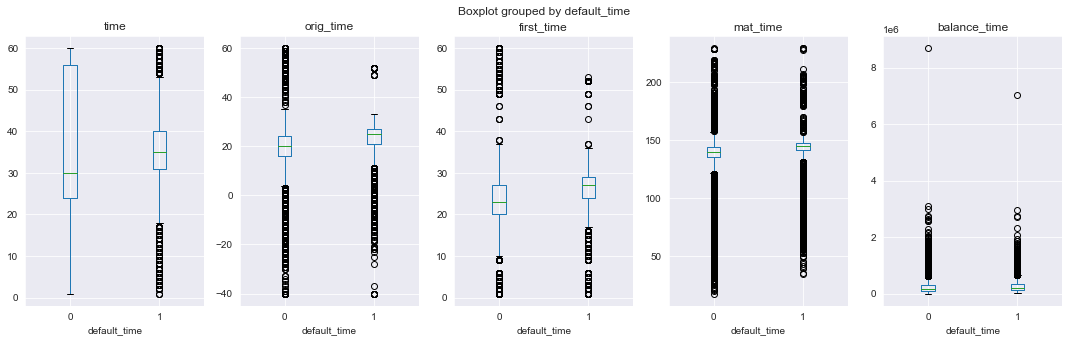

In [1255]:
GraphicalAnalysis(df,"default_time",continuous_var[0:5])

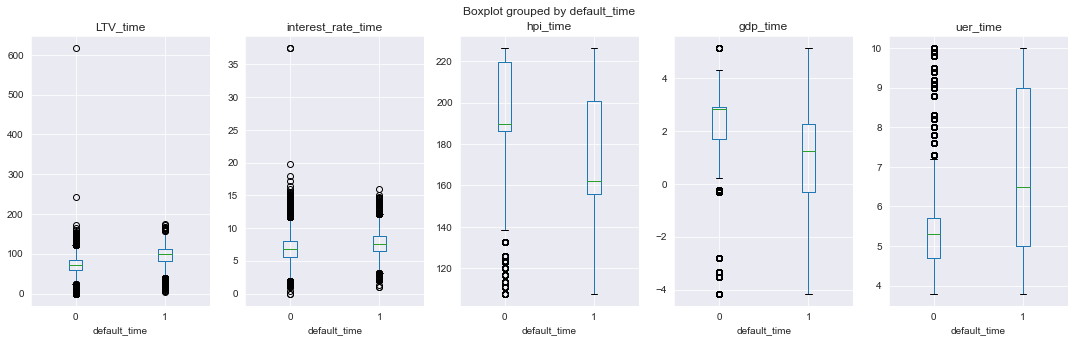

In [1256]:
GraphicalAnalysis(df,"default_time",continuous_var[5:10])

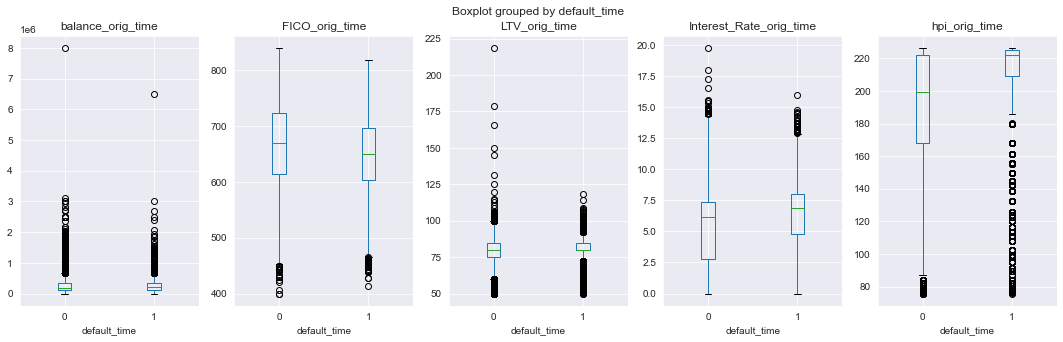

In [1257]:
GraphicalAnalysis(df,"default_time",continuous_var[10:15])

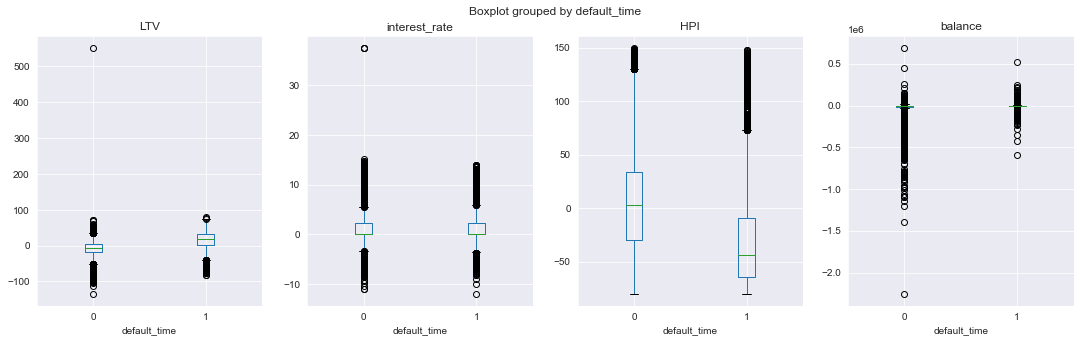

In [1258]:
GraphicalAnalysis(df,"default_time",continuous_var[15:])

confirmation statistique : Analyse ANOVA
--

In [1259]:
# à integrer dans la fonction "utils.py"
def AnovaFunction(data, Target, Continuous_variable):
  
    """
    -----------------------------------------------------------------------------------------
    Cette fonction est une implementation du test Anova pour étudier la correlation 
    entre l'ensemble des variables explicatives continues et la variable cible categorielle.

    hypothese de test (H0) : la varaible Target est correlé a la variable Continuous_variable
    decision : on accepte(H0) si p-value est superieur a 0.05 (soit 5%).
  -----------------------------------------------------------------------------------------

    Paramètre : 
    ___________

    - data : Jeu d données -> DataFrame 
    - Target : variable cible -> str (chain de caractère)
    - Continuous_variable : ensemble des variable continue -> list()

    Sortie : 
    ______

    - variables : liste des variables explicative continue correlé à la varaible cible categorielle  -> list()
    """

    from scipy.stats import f_oneway

    variables=[]
    
    print('\033[1m'+ '##### ANOVA Results ##### \n'+'\033[0m')
    for predictor in Continuous_variable:
        CategoryGroupLists=data.groupby(Target)[predictor].apply(list)
        AnovaResults = f_oneway(*CategoryGroupLists)
        
        # If the ANOVA P-Value is <0.05, that means we reject H0
        if (AnovaResults[1] < 0.05):
            print("{:<25} est correlé à {:<25} | P-Value: {}".format(predictor,"la variable cible",AnovaResults[1]))
            variables.append(predictor)
        else:
            print( "\033[1m{:<24} \033[0m n'est pas correlé à {:<19} | P-Value: {}".format(predictor,"la variable cible",AnovaResults[1]))
    
    return(variables)

In [1260]:
continuous_feature = AnovaFunction(df,"default_time",continuous_var)

##### ANOVA Results ##### 

time                      est correlé à la variable cible         | P-Value: 7.609386378357591e-07
orig_time                 est correlé à la variable cible         | P-Value: 0.0
first_time                est correlé à la variable cible         | P-Value: 7.430416665678869e-163
mat_time                  est correlé à la variable cible         | P-Value: 0.0
balance_time              est correlé à la variable cible         | P-Value: 8.680871208731664e-23
LTV_time                  est correlé à la variable cible         | P-Value: 0.0
interest_rate_time        est correlé à la variable cible         | P-Value: 5.079126665919559e-279
hpi_time                  est correlé à la variable cible         | P-Value: 0.0
gdp_time                  est correlé à la variable cible         | P-Value: 0.0
uer_time                  est correlé à la variable cible         | P-Value: 0.0
balance_orig_time         n'est pas correlé à la variable cible   | P-Value: 0.289464333

In [1261]:
# à integrer dans la fonction "utils.py"

def Profil_plot(data,categorical_variable,target):

    """
    -----------------------------------------------------------------------------------------
    Cette fonction propose une visulisation la correlation entre l'ensemble 
    des variables explicatives categorielle et la variable cible categorielle.
    -----------------------------------------------------------------------------------------

    Paramètre : 
    ___________

    - data : Jeu d données -> DataFrame 
    - target : variable cible -> str (chain de caractère)
    - categorical_variable : ensemble des variable continue -> list()

    Sortie : 
    ______

    - graphique  -> Barplot()
    
    """

    fig, PlotCanvas = plt.subplots(nrows=1, ncols=len(categorical_variable), figsize=(25,10))
    for CategoricalCol , i in zip(categorical_variable, range(len(categorical_variable))):
        CrossTabResult=pd.crosstab(index=data[CategoricalCol], columns=data[target])
        CrossTabResult.plot.bar(color=['C7','C10'], ax=PlotCanvas[i])

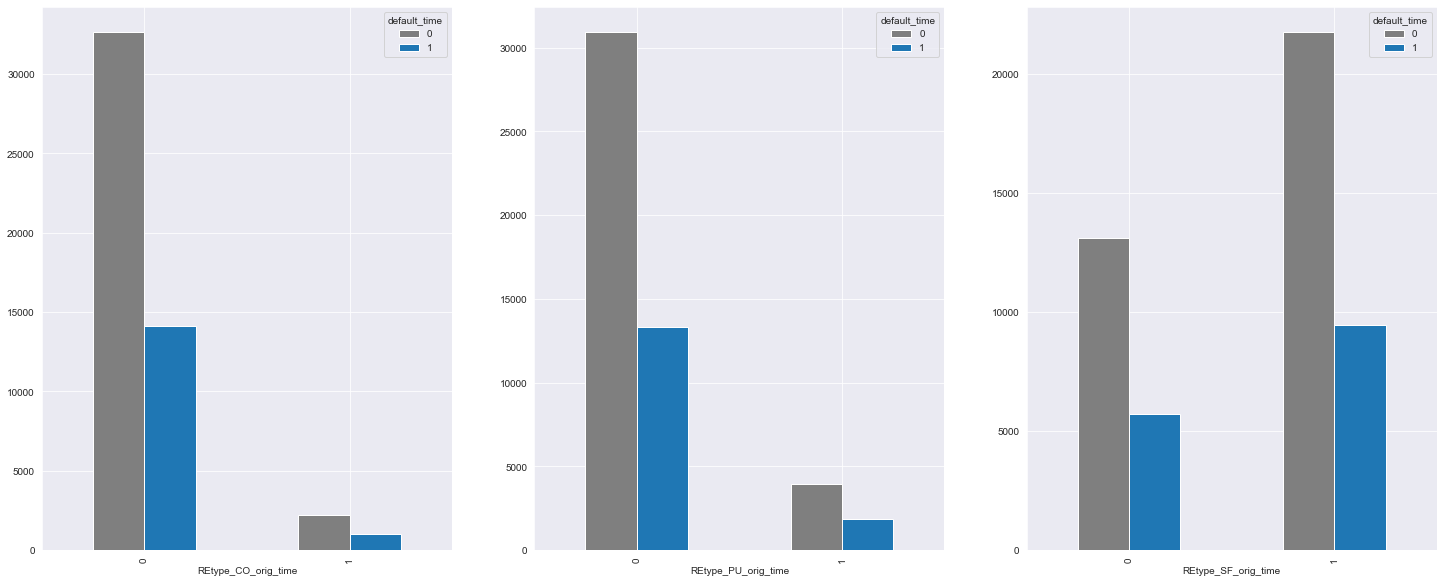

In [1266]:
Profil_plot(df,categorical_variable[0:3],"default_time")

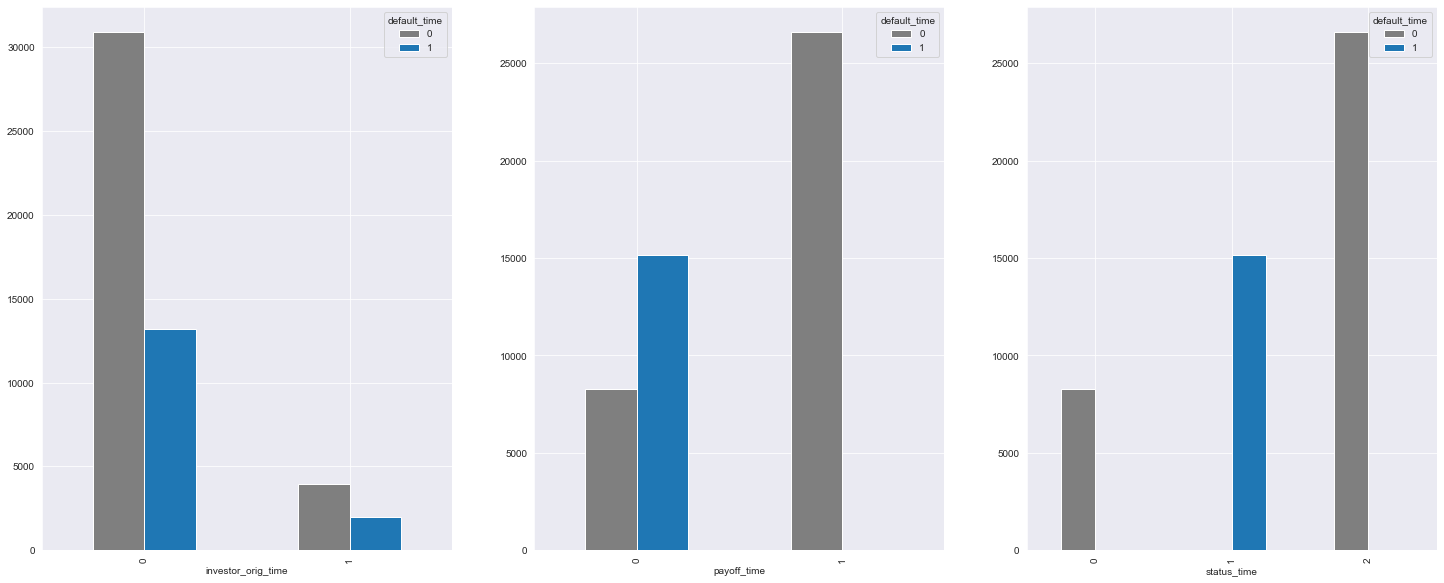

In [1268]:
Profil_plot(df,categorical_variable[3:],"default_time")

confirmation statistique : tets de Khi-2
--

In [1269]:
# à integrer dans la fonction "utils.py"

def ChisqFunction(data, Target, categorical_var):

    """
    -----------------------------------------------------------------------------------------
    Cette fonction est une implementation du test de Khi-2 pour étudier la correlation 
    entre l'ensemble des variables explicatives categorielle et la variable cible categorielle.

    hypothese de test (H0) : la varaible Target est correlé a la variable categorical_variable
    decision : on accepte(H0) si p-value est superieur a 0.05 (soit 5%).
    -----------------------------------------------------------------------------------------

    Paramètre : 
    ___________

    - data : Jeu d données -> DataFrame 
    - Target : variable cible -> str (chain de caractère)
    - categorical_variable : ensemble des variable categorielle -> list()

    Sortie : 
    ______

    - variables : liste des variables explicative categorielle correlé à la varaible cible categorielle  -> list()
    """

    from scipy.stats import chi2_contingency
    
    # Creating an empty list of final selected predictors
    SelectedPredictors=[]

    for predictor in categorical_var:
        CrossTabResult=pd.crosstab(index=data[Target], columns=data[predictor])
        ChiSqResult = chi2_contingency(CrossTabResult)
        
    # If the ChiSq P-Value is <0.05, that means we reject H0
        if (ChiSqResult[1] < 0.05):
            print(predictor, 'est correlé à', "la variable cible", '| P-Value:', ChiSqResult[1])
            SelectedPredictors.append(predictor)
        else:
            print("\033[1m"+predictor+"\033[0m", "n'est pas correlé à", "la variable cible", '| P-Value:', ChiSqResult[1])        
            
    return(SelectedPredictors)

In [1270]:
categorical_feature = ChisqFunction(df,"default_time",categorical_variable)

REtype_CO_orig_time n'est pas correlé à la variable cible | P-Value: 0.1430146915880258
REtype_PU_orig_time est correlé à la variable cible | P-Value: 0.003364685255051021
REtype_SF_orig_time n'est pas correlé à la variable cible | P-Value: 0.8462133733102897
investor_orig_time est correlé à la variable cible | P-Value: 6.438580988079101e-07
payoff_time est correlé à la variable cible | P-Value: 0.0
status_time est correlé à la variable cible | P-Value: 0.0


Selection final de variable
--

In [1271]:
selected_continuous_feature = list()
selected_categorial_feature = list()
for c in continuous_feature:
    selected_continuous_feature.append(c)

for j in categorical_feature:
    selected_categorial_feature.append(j)

predictor = selected_categorial_feature + selected_continuous_feature
len(predictor)
predictor

['REtype_PU_orig_time',
 'investor_orig_time',
 'payoff_time',
 'status_time',
 'time',
 'orig_time',
 'first_time',
 'mat_time',
 'balance_time',
 'LTV_time',
 'interest_rate_time',
 'hpi_time',
 'gdp_time',
 'uer_time',
 'FICO_orig_time',
 'LTV_orig_time',
 'Interest_Rate_orig_time',
 'hpi_orig_time',
 'LTV',
 'interest_rate',
 'HPI',
 'balance']

In [1272]:
final_df = df[predictor]

In [1273]:
final = pd.concat([endog,final_df],axis = 1)

In [1274]:
def get_best_correlate_var(data,target,threshold,plot=True):


     #-------------------- Buld dataframe -----------------------#
    
    coef = list()
    for i in data.columns.tolist():
        corr = data[target].corr( data[i]).tolist()
        coef.append(corr)
    corr_table = pd.DataFrame(coef,index= data.columns.tolist(),columns=['coefficient'])
    var = [c for c in corr_table.loc[abs(corr_table["coefficient"]) > threshold].index]
    
    #-------------------- Plot corralation matrix -----------------------#
    if plot == True:
        plt.figure(figsize=(9,9))
        sns.heatmap(corr_table,annot=True,linewidths=1)
        plt.title('Figure4 : Default_time correletion graph ');
    
    return var

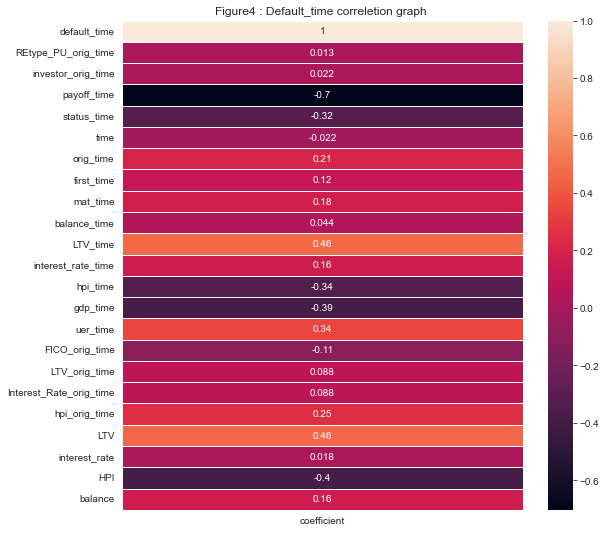

In [1275]:
final_selector = get_best_correlate_var(final,"default_time",0.1,True)

In [1282]:
#ici on fait parler l'intuition et l'esprit critique
liste_ = ["time","orig_time","first_time","status_time","LTV_time","hpi_time","hpi_orig_time","investor_orig_time"]
final_predictor = list()
for c in final_selector:
    if c not in liste_:
        try:
            final_predictor.append(c)
        except Exception as e:
            pass
final_predictor.append("investor_orig_time")

In [1283]:
f_ = final[final_predictor]
classes = sc.woebin(f_, y="default_time", positive=1, method="chimerge",bin_num_limit=12)

[INFO] creating woe binning ...
Binning on 50000 rows and 11 columns in 00:00:26


In [1284]:
# pour confirmer le choix des varaible en terme IV apporter à la comprehension du phenomen

def cheick_IV(data,obj):
    """
    http://ucanalytics.com/blogs/information-value-and-weight-of-evidencebanking-case/
    
    IV_ = cheick_IV(f_,classes)
    """
    print("-"*45)
    print("{:<25}{}".format("Variable","IV"))
    print("-"*45)
    for c in data.columns:
        try:
            print("{:<25}{}".format(c,obj[c]["total_iv"].values[0]))
        except:
            pass
    print("-"*45)

In [1285]:
col = ['default_time','mat_time','interest_rate_time','gdp_time','uer_time','FICO_orig_time','LTV','HPI','balance','investor_orig_time','payoff_time']

In [1286]:
cheick_IV(f_,classes)

---------------------------------------------
Variable                 IV
---------------------------------------------
payoff_time              0.0
mat_time                 0.6038571750427961
interest_rate_time       0.204571133784422
gdp_time                 0.849700667915538
uer_time                 0.6512995886176017
FICO_orig_time           0.10820677935942798
LTV                      1.426766456054681
HPI                      1.1850291339685148
balance                  0.4908276426063979
investor_orig_time       0.002311084694756031
---------------------------------------------


Constucrtion de la base final
--

In [1287]:
def Create_final_dataset(data, columns, shuffle=True):
   
    from numpy.random import permutation
    dt = data[columns]
    
    if shuffle:
        dt = dt.reset_index(drop=True)
        ind = permutation(dt.index)
        dt = dt.iloc[ind, :].reset_index(drop=True)
    return dt

dataset = Create_final_dataset(df,final_predictor,shuffle=True)

In [1288]:
for c in base_model.columns:
    print(c)

mat_time
interest_rate_time
gdp_time
uer_time
FICO_orig_time
LTV
HPI
balance
gdp
payoff_time
investor_orig_time
default_time
gdp.1


Traitement des données aberrante
--

In [1289]:
def Outliers_Remove(data,seuil):
    
    # resource : https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba ou seuil = |3|
    
    import scipy.stats as stats

    #find absolute value of z-score for each observation
    z = np.abs(stats.zscore(data))

    #only keep rows in dataframe with all z-scores less than absolute value of 3 
    data_cleans = data[(z < seuil).all(axis = 1)]

    #find how many rows are left in the dataframe 

    Q1 = data.quantile(q = 0.25)
    Q3 = data.quantile(q = 0.75)
    IQR = data.apply(stats.iqr)

    #only keep rows in dataframe that have values within 1.5*IQR of Q1 and Q3
    data_clean = data[~((data < (Q1 - 1.5*IQR)) | (data > (Q3 + 1.5*IQR))).any(axis = 1)]

    #find how many rows are left in the dataframe 
    return data_clean

In [1290]:
dts = dataset.copy()
df_ = Outliers_Remove(dts,3)

Creation de classes de variables 
==


Identification des classes
--

In [1291]:
# Création de couple target - features dans le train  et test set
train, test = train_test_split(df_, test_size = 0.2, random_state = 42)
classes = sc.woebin(df_, y="default_time", positive=1, method="chimerge",bin_num_limit=12)
train_woe = sc.woebin_ply(train, classes)
test_woe = sc.woebin_ply(test, classes)
y_train = train_woe["default_time"]
X_train = train_woe.drop(["default_time"], axis =1)

y_test = test_woe["default_time"]
X_test = test_woe.drop(["default_time"], axis =1)

[INFO] creating woe binning ...
Binning on 26979 rows and 10 columns in 00:00:19
[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [1292]:
class GroupingClass(object):
    
    def __init__(self,data,target,seuil):
        
        import scorecardpy as sc
        
        self.data = data
        self.target = target
        self.seuil = seuil
        
        self.cls = sc.woebin(self.data, y=self.target, positive=1, method="chimerge",bin_num_limit=self.seuil)
        
    def IV_WoE_Table(self,var,plot = True):
        dt = self.cls[var][["variable","bin","count","good","bad","badprob","woe","bin_iv","total_iv"]]
        dt = dt.reset_index()
        dt.columns = ["Classe","variable","bin","count","good","bad","badprob","woe","bin_iv","total_iv"]
        if plot == True:
            sc.woebin_plot(self.cls[var]);
        return dt

In [1293]:
ca_var = list(dataset.nunique()[dataset.nunique()<4].index)
co_var = list(dataset.nunique()[dataset.nunique()>4].index)
ca_var

['default_time', 'payoff_time', 'investor_orig_time']

In [1294]:
cheick = GroupingClass(df_.drop(["payoff_time","investor_orig_time"],axis=1),"default_time",12)

[INFO] creating woe binning ...
Binning on 26979 rows and 9 columns in 00:00:19


In [1295]:
# summary pour le regroupement des classe de chaque variable continue selectionner 

dico_classe = {
    "variable 1" : {
        "variable" :co_var[0],
        "groupe 1" : (0,1,2,3),
        "groupe 2" : (4,5,6),
        "groupe 3" : (7,8)
                             },
    "variable 2" : {
        "variable":co_var[1],
        "groupe 1" : (0,1),
        "groupe 2" : (2,3,4)
                             },
    "variable 3" : {
        "variable":co_var[2] ,
        "groupe 1" : (0,1),
        "groupe 2" : (2,3)
                             },
    "variable 4" : {
        "variable":co_var[3] ,
        "groupe 1" : (0,1),
        "groupe 2" : (2)
                             },
    "variable 5" : {
        "variable":co_var[4],
        "groupe 1" : (0,1,2,3,4,5),
        "groupe 2" : (6,7)
                             },
    "variable 6" : {
        "variable":co_var[5] ,
        "groupe 1" : (0,1,2,3,4),
        "groupe 2" : (5,6,7),
        "groupe 3" : (8,9)
                             },
    "variable 7" : {
        "variable":co_var[6],
        "groupe 1" : (0),
        "groupe 2" : (1,3,4),
        "groupe 3" : (2,5,6,7,8,9)
                             },
    "variable 8" : {
        "variable":co_var[7] ,
        "groupe 1" : (0,1),
        "groupe 2" : (2,3),
        "groupe 3" : (4,5,6)
                             },
}

res = pd.DataFrame(dico_classe)
res.to_csv("table_classe.csv")

construction de categorie pour la base final
--

,Classe,variable,bin,count,good,bad,badprob,woe,bin_iv,total_iv
0,0,gdp_time,"[-inf,1.0)",2420,999,1421,0.587190,1.381739,0.207062,0.764199
1,1,gdp_time,"[1.0,2.0)",7533,4231,3302,0.438338,0.781468,0.197052,0.764199
2,2,gdp_time,"[2.0,3.0)",11294,9457,1837,0.162653,-0.609243,0.132240,0.764199
3,3,gdp_time,"[3.0,inf)",5732,5191,541,0.094382,-1.231884,0.227845,0.764199


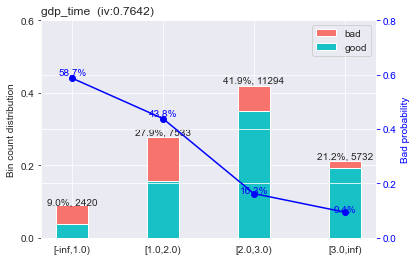

In [1296]:
u = cheick.IV_WoE_Table(co_var[2],True)
u

In [1297]:
u["variable"][0]

'gdp_time'

In [1298]:
#sl1 = [c for c in u.loc[(u["Classe"] == 0) | (u["Classe"] == 1)]["woe"]]
sl2 = [c for c in u.loc[(u["Classe"] == 2) | (u["Classe"] == 3)]["woe"]]
sl3 = [c for c in u.loc[(u["Classe"] == 4) | (u["Classe"] == 5) | (u["Classe"] == 6)]["woe"]]

In [1299]:
data_set = sc.woebin_ply(df_.drop(["payoff_time","investor_orig_time"],axis=1), classes)

[INFO] converting into woe values ...


In [1300]:
#data_sets = pd.DataFrame([])

In [1301]:
##-----construction de la modalité------#

#list_cat = list()
#for c in data_set["balance_woe"]:
#    if c in sl1 :
#        list_cat.append("balance_G1")
#    elif c in sl2:
#        list_cat.append("balance_G2")
#    elif c in sl3:
#        list_cat.append("balance_G3")

#-----construction de la variable------#
#data_sets["balance_grouped"] = list_cat

In [1302]:
#list_ = list()
#for c in df_["gdp_time"]:
#    if c < 0 :
#        list_.append("gdp_time_nef")
#    else:
#        list_.append("gdp_time_pos")
#data_sets["gdp_time_calc"] = list_

#data_sets["payoff_time"] = df_["payoff_time"].values
#data_sets["investor_orig_time"] = df_["investor_orig_time"].values
#data_sets["default_time"] = df_["default_time"].values
#data_sets.columns = [c.replace("_grouped","").replace("_time_calc","") for c in data_sets.columns]
#data_sets.to_csv("base_modele_final.csv")

## Base final

In [1303]:
#base_model = pd.read_csv("base_modele_final.csv") # la base a été stocké sur github
base_model = pd.read_csv("https://raw.githubusercontent.com/wilflex/CREDIT_RISK_PROJECT/main/base_modele_final.csv")
base_model.drop(["Unnamed: 0"],axis = 1,inplace=True)
clas_df = sc.woebin(base_model, y="default_time", positive=1, method="chimerge")

[INFO] creating woe binning ...


In [1304]:
base_model.columns

Index(['mat_time', 'interest_rate_time', 'gdp_time', 'uer_time',
       'FICO_orig_time', 'LTV', 'HPI', 'balance', 'gdp', 'payoff_time',
       'investor_orig_time', 'default_time', 'gdp.1'],
      dtype='object')

In [1306]:
#verification de la coherance des classes
for c in base_model.columns:
    try:
        print("{:<20}{:<5}".format(c,base_model[c].nunique()),len(clas_df[c]["variable"]))
    except:
        pass

mat_time            3     3
interest_rate_time  2     2
gdp_time            2     2
uer_time            2     2
FICO_orig_time      2     2
LTV                 3     3
HPI                 3     3
balance             3     3
gdp                 2     1
payoff_time         2     1
gdp.1               2     1


In [1307]:
#verification de la pertinance des classes
for c in base_model.columns:
    try:
        display(clas_df[c])
        print("\n")
    except:
        pass

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,mat_time,mat_time_G1,12628,0.468068,10958,1670,0.132246,-0.851868,0.269262,0.521071,mat_time_G1,False
1,mat_time,mat_time_G2,6218,0.230476,4478,1740,0.279833,0.084087,0.001662,0.521071,mat_time_G2,False
2,mat_time,balance_G3,8133,0.301457,4442,3691,0.453830,0.844171,0.250147,0.521071,balance_G3,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,interest_rate_time,interest_rate_time_G1,11893,0.440824,9832,2061,0.173295,-0.533073,0.108948,0.178356,interest_rate_time_G1,False
1,interest_rate_time,interest_rate_time_G2,15086,0.559176,10046,5040,0.334085,0.339610,0.069408,0.178356,interest_rate_time_G2,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,gdp_time,gdp_time_G2,17026,0.631083,14648,2378,0.139669,-0.788666,0.317054,0.689885,gdp_time_G2,False
1,gdp_time,gdp_time_G1,9953,0.368917,5230,4723,0.474530,0.927411,0.372831,0.689885,gdp_time_G1,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,uer_time,uer_time_G1,24748,0.917306,19062,5686,0.229756,-0.180312,0.028528,0.278488,uer_time_G1,False
1,uer_time,uer_time_G2,2231,0.082694,816,1415,0.634245,1.579848,0.249959,0.278488,uer_time_G2,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FICO_orig_time,FICO_orig_time_G2,7626,0.282664,6221,1405,0.184238,-0.458515,0.052775,0.070603,FICO_orig_time_G2,False
1,FICO_orig_time,FICO_orig_time_G1,19353,0.717336,13657,5696,0.294321,0.154890,0.017828,0.070603,FICO_orig_time_G1,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LTV,LTV_G1,15125,0.560621,13181,1944,0.128529,-0.884651,0.344422,0.889165,LTV_G1,False
1,LTV,LTV_G2,7936,0.294155,5391,2545,0.320691,0.278778,0.024308,0.889165,LTV_G2,False
2,LTV,LTV_G3,3918,0.145224,1306,2612,0.666667,1.722525,0.520435,0.889165,LTV_G3,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,HPI,HPI_G3,17774,0.658809,15217,2557,0.143862,-0.754201,0.305775,0.83973,HPI_G3,False
1,HPI,HPI_G2,5733,0.212499,3489,2244,0.391418,0.588023,0.082612,0.83973,HPI_G2,False
2,HPI,HPI_G1,3472,0.128693,1172,2300,0.662442,1.703575,0.451343,0.83973,HPI_G1,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,balance,balance_G1,3969,0.147114,3329,640,0.161250,-0.619581,0.047921,0.102916,balance_G1,False
1,balance,balance_G2,10523,0.390044,8108,2415,0.229497,-0.181774,0.012323,0.102916,balance_G2,False
2,balance,balance_G3,12487,0.462841,8441,4046,0.324017,0.294006,0.042672,0.102916,balance_G3,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,gdp,"gdp_time_pos%,%gdp_time_nef",26979,1.0,19878,7101,0.263205,0.0,0.0,0.0,"gdp_time_pos%,%gdp_time_nef",False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,payoff_time,"[-inf,inf)",26979,1.0,19878,7101,0.263205,0.0,0.0,0.0,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,gdp.1,"gdp_time_pos%,%gdp_time_nef",26979,1.0,19878,7101,0.263205,0.0,0.0,0.0,"gdp_time_pos%,%gdp_time_nef",False


Modelisation
==

In [1308]:
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

# Création de couple target - features dans le train  et test set
train, test = train_test_split(base_model, test_size = 0.2, random_state = 42)
train_woe = sc.woebin_ply(train, clas_df)
test_woe = sc.woebin_ply(test, clas_df)
y_train = train_woe["default_time"]
X_train = train_woe.drop(["default_time"], axis =1)
y_test = test_woe["default_time"]
X_test = test_woe.drop(["default_time"], axis =1)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


Identification des paramettres Optimaux
--

In [1309]:
from sklearn import set_config
set_config(display="diagram")

In [1310]:
def Found_Best_Paramas(model, X_train, y_train):

    if model == "RandomForestClassifier":
        estimateur =RandomForestClassifier()
        print("RandomForestClassifier")
        print("-"*len(str(estimateur)))
        params = {"n_estimators":list(range(5, 26, 10)), 
                  'max_depth':list(range(25, 101, 25)), 
                "max_features" : list(range(3, X_train.shape[1]+1, 1))}
        gs = GridSearchCV(estimateur,
              param_grid=params,
              scoring="roc_auc", return_train_score=True, cv = 5)
        t1 = time.time()
        gs.fit(X_train, y_train)
        results = gs.cv_results_
        t2 = time.time() - t1
        
    if model == "KNeighborsClassifier":
        estimateur = KNeighborsClassifier()
        print("KNeighborsClassifier")
        print("-"*len(str(estimateur)))
        params = {"n_neighbors":list(range(5, 50, 15))}
        gs = GridSearchCV(estimateur,
              param_grid=params,
              scoring="roc_auc", return_train_score=True, cv = 5)
        t1 = time.time()
        gs.fit(X_train, y_train)
        results = gs.cv_results_
        t2 = time.time() - t1
        
    if model == "DecisionTreeClassifier":
        estimateur = DecisionTreeClassifier()
        print("DecisionTreeClassifier")
        print("-"*len(str(estimateur)))
        params = {'max_depth':list(range(2, 21, 2)), "max_features" : list(range(3, X_train.shape[1]+1, 1))}
        gs = GridSearchCV(estimateur,
              param_grid=params,
              scoring="roc_auc", return_train_score=True, cv = 5)
        t1 = time.time()
        gs.fit(X_train, y_train)
        results = gs.cv_results_
        t2 = time.time() - t1
        
    if model == "GradientBoostingClassifier":
        estimateur = GradientBoostingClassifier()
        print("GradientBoostingClassifier")
        print("-"*len(str(estimateur)))
        params = {'n_estimators': list(range(5, 26, 10)),'learning_rate': [0.05, 0.1,0.2],'max_depth': [1, 2, 5]}
        gs = GridSearchCV(estimateur,
              param_grid=params,
              scoring="roc_auc", return_train_score=True, cv = 5)
        t1 = time.time()
        gs.fit(X_train, y_train)
        results = gs.cv_results_
        t2 = time.time() - t1
        
    if model == "LinearDiscriminantAnalysis":
        estimateur = LinearDiscriminantAnalysis()
        print("LinearDiscriminantAnalysis")
        print("-"*len(str(estimateur)))
        params = {}
        gs = GridSearchCV(estimateur,
              param_grid=params,
              scoring="roc_auc", return_train_score=True, cv = 5)
        t1 = time.time()
        gs.fit(X_train, y_train)
        results = gs.cv_results_
        t2 = time.time() - t1
    
    if model == "LogisticRegression":
        
        estimateur = LogisticRegression()
        
        print("LogisticRegression")
        print("-"*len(str(estimateur)))
        
        params = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
        gs = GridSearchCV(estimateur,
              param_grid=params,
              scoring="roc_auc", return_train_score=True, cv = 5)
        t1 = time.time()
        gs.fit(X_train, y_train)
        results = gs.cv_results_
        t2 = time.time() - t1
        
    print("L'opération a pris %.2fs" %t2)
    print("Les meilleurs paramètres sont:", gs.best_params_)
    print("Le meilleur score AUC est: %.2f" %gs.best_score_)
    
    return  gs

In [1311]:
rfc = Found_Best_Paramas("RandomForestClassifier",X_train,y_train )

RandomForestClassifier
------------------------
L'opération a pris 203.14s
Les meilleurs paramètres sont: {'max_depth': 100, 'max_features': 12, 'n_estimators': 25}
Le meilleur score AUC est: 0.82


In [1312]:
knc = Found_Best_Paramas("KNeighborsClassifier",X_train,y_train )

KNeighborsClassifier
----------------------
L'opération a pris 61.09s
Les meilleurs paramètres sont: {'n_neighbors': 35}
Le meilleur score AUC est: 0.79


In [1313]:
dtc = Found_Best_Paramas("DecisionTreeClassifier",X_train,y_train )

DecisionTreeClassifier
------------------------
L'opération a pris 23.78s
Les meilleurs paramètres sont: {'max_depth': 8, 'max_features': 7}
Le meilleur score AUC est: 0.82


In [1314]:
gbc = Found_Best_Paramas("GradientBoostingClassifier",X_train,y_train )

GradientBoostingClassifier
----------------------------
L'opération a pris 34.96s
Les meilleurs paramètres sont: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 25}
Le meilleur score AUC est: 0.83


In [1315]:
lda = Found_Best_Paramas("LinearDiscriminantAnalysis",X_train,y_train )

LinearDiscriminantAnalysis
----------------------------
L'opération a pris 1.04s
Les meilleurs paramètres sont: {}
Le meilleur score AUC est: 0.82


In [1316]:
lr = Found_Best_Paramas("LogisticRegression",X_train,y_train )

LogisticRegression
--------------------
L'opération a pris 5.41s
Les meilleurs paramètres sont: {'C': 1, 'penalty': 'l2'}
Le meilleur score AUC est: 0.82


Construction des modèles
--

In [1317]:
modele = [RandomForestClassifier(max_depth = 50, max_features = 7, n_estimators = 25),
         KNeighborsClassifier(n_neighbors = 35),DecisionTreeClassifier(max_depth = 8, max_features = 8),
         GradientBoostingClassifier(learning_rate = 0.1, max_depth = 5, n_estimators = 25),
         LinearDiscriminantAnalysis(),LogisticRegression(C =  1, penalty = 'l2')]

Analyse des performance du modèle
--

In [1318]:
def Model_Perf_Analysis(model, X_train, y_train, X_test, y_test, 
          smote = True, show_roc = True, show_conf_matrix = True, cut_off = 0.45, show_prc = False) : 
    
    #--------Expression regulier pour convertir le fonction en chaine de caractere pour le titre de graphe---------#
    b = re.findall(r"[A-Za-z0-9]+", str(model)) 
    
    #---------------------------------------------requilibrage des données-----------------------------------------#
    if smote == True:
        print("SMOTE")
        print("--------")
        from imblearn.over_sampling import SMOTE
        smote = SMOTE(random_state=42 , k_neighbors=15)
        X_train, y_train = smote.fit_resample(X_train, y_train)
    
    #-------------------------------------------------mise en marche du modele-------------------------------------#
    lr = model.fit(X_train, y_train)
    print("train score %.2f" %lr.score(X_train, y_train))
    print("--------")
    
    #--------------------------------------------determination des y-pred-----------------------------------------#
    train_pred = lr.predict_proba(X_train)[:,1]
    test_pred = lr.predict_proba(X_test)[:,1]
    print("test score %.2f" %lr.score(X_test, y_test))
    print("--------")
    print("Cut-off : ", cut_off)
    
    
    #--determination de metrique (accuracy, precision et toute la clique au seuil de 50% de confiance (standard))--#
    print("--------")
    print("classification_report\n")
    test_pred_b = (test_pred > cut_off).astype(bool)
    train_pred_b = (train_pred > cut_off).astype(bool)
    print(classification_report(y_test, test_pred_b))
    print("\n")

    train_pred_b = (train_pred > cut_off).astype(bool)
    
    #----------------------------- determinetion de la matrice de confusion--------------------------------------#
    if show_conf_matrix == True : 
        print("Matrice de confusion\n")
        print(confusion_matrix(y_test, test_pred_b))
        print("--------")
        #AUC
    fpr, tpr, _= roc_curve(y_test, test_pred)
    roc_auc = auc(fpr, tpr)
    fpr_, tpr_, _train= roc_curve(y_train, train_pred)
    roc_auc_ = auc(fpr_, tpr_)
    print("L'AUC est de %.2f" %roc_auc)
    print("--------")
    Gini = roc_auc * 2 - 1
    print('Gini: %.2f' % (Gini))
    print("--------")
    
    
    #------------------------------------Graphe de la courbe de roc-----------------------------------------#
    if show_roc == True:
        print('roc curve')
        
        plt.figure(figsize=(6,6))
        plt.xlim([-0.01, 1.00])
        plt.ylim([-0.01, 1.01])
        plt.plot(fpr, tpr, lw=3, label='roc curve - Test (auc = {:0.2f})'.format(roc_auc))
        #plt.plot(fpr_, tpr_, lw=3, label='roc curve - Train (auc = {:0.2f})'.format(roc_auc_))
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.title(b[0], fontsize=16)
        plt.legend(loc='lower right', fontsize=13)
        plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
        #plt.axes().set_aspect('equal')
        plt.show()
        print("\n")
        
    #-------------------------------------Graphe de la precision et du recall--------------------------------------#   
    
    precision, recall, thresholds = precision_recall_curve(y_test, test_pred)
    precision_, recall_, thresholds_ = precision_recall_curve(y_train, train_pred)
    
    closest_zero = np.argmin(np.abs(thresholds))
    closest_zero_p = precision[closest_zero]
    closest_zero_r = recall[closest_zero]
    
    closest_zero_ = np.argmin(np.abs(thresholds_))
    closest_zero_p_ = precision_[closest_zero_]
    closest_zero_r_ = recall_[closest_zero_]
    
    if show_prc == True : 
        
        print("precision_recall_curve")
        #plt.figure(figsize = (6,6))
        plt.xlim([0.0, 1.01])
        plt.ylim([0.0, 1.01])
        plt.plot(precision, recall, label='prc - Test')
        plt.xlabel('Precision', fontsize=16)
        plt.ylabel('Recall', fontsize=16)
        plt.axes().set_aspect('equal')
        plt.legend(loc='lower left', fontsize=13)
        plt.show()

    J = tpr - fpr
    ix = np.argmax(J)
    seuil_opt = thresholds[ix]
    
    J_ = tpr_ - fpr_
    ix_ = np.argmax(J_)
    seuil_opt_ = thresholds_[ix_]
    print('Meilleur cut-off test : %f' % (seuil_opt))
    print('Meilleur cut-off train : %f' % (seuil_opt_))
    
    return fpr, tpr, roc_auc

In [1320]:
for c in modele:
    print(str(c))

RandomForestClassifier(max_depth=50, max_features=7, n_estimators=25)
KNeighborsClassifier(n_neighbors=35)
DecisionTreeClassifier(max_depth=8, max_features=8)
GradientBoostingClassifier(max_depth=5, n_estimators=25)
LinearDiscriminantAnalysis()
LogisticRegression(C=1)


SMOTE
--------
train score 0.78
--------
test score 0.77
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.88      0.76      0.82      3953
           1       0.52      0.73      0.61      1443

    accuracy                           0.75      5396
   macro avg       0.70      0.74      0.71      5396
weighted avg       0.79      0.75      0.76      5396



Matrice de confusion

[[2989  964]
 [ 391 1052]]
--------
L'AUC est de 0.81
--------
Gini: 0.62
--------
roc curve


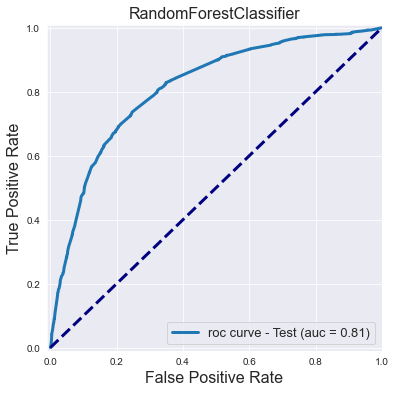



Meilleur cut-off test : 0.503895
Meilleur cut-off train : 0.740449


In [1321]:
fpr_r, tpr_r, roc_auc_r = Model_Perf_Analysis( model = modele[0],X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test)

SMOTE
--------
train score 0.70
--------
test score 0.78
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      3953
           1       0.58      0.53      0.56      1443

    accuracy                           0.77      5396
   macro avg       0.71      0.70      0.70      5396
weighted avg       0.77      0.77      0.77      5396



Matrice de confusion

[[3404  549]
 [ 671  772]]
--------
L'AUC est de 0.80
--------
Gini: 0.60
--------
roc curve


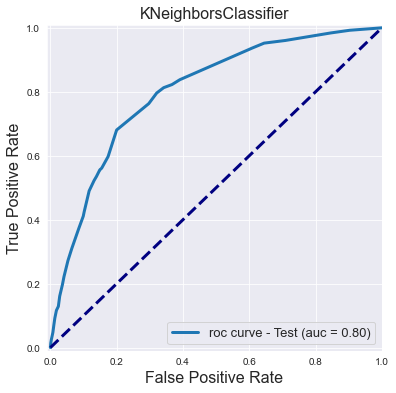



Meilleur cut-off test : 0.685714
Meilleur cut-off train : 0.685714


In [1322]:
fpr_k, tpr_k, roc_auc_k = Model_Perf_Analysis( model = modele[1],X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test)

SMOTE
--------
train score 0.77
--------
test score 0.77
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.89      0.75      0.82      3953
           1       0.52      0.73      0.61      1443

    accuracy                           0.75      5396
   macro avg       0.70      0.74      0.71      5396
weighted avg       0.79      0.75      0.76      5396



Matrice de confusion

[[2984  969]
 [ 385 1058]]
--------
L'AUC est de 0.81
--------
Gini: 0.62
--------
roc curve


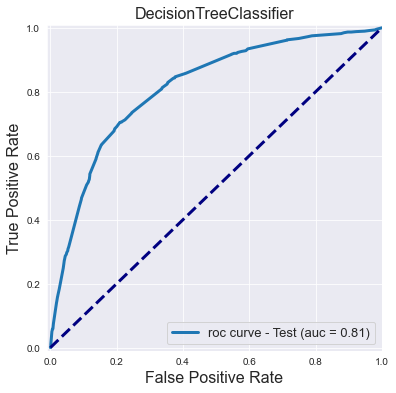



Meilleur cut-off test : 0.507553
Meilleur cut-off train : 0.500000


In [1323]:
fpr_d, tpr_d, roc_auc_d = Model_Perf_Analysis( model = modele[2],X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test)

SMOTE
--------
train score 0.77
--------
test score 0.77
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.89      0.76      0.82      3953
           1       0.53      0.74      0.62      1443

    accuracy                           0.76      5396
   macro avg       0.71      0.75      0.72      5396
weighted avg       0.79      0.76      0.77      5396



Matrice de confusion

[[3024  929]
 [ 380 1063]]
--------
L'AUC est de 0.82
--------
Gini: 0.63
--------
roc curve


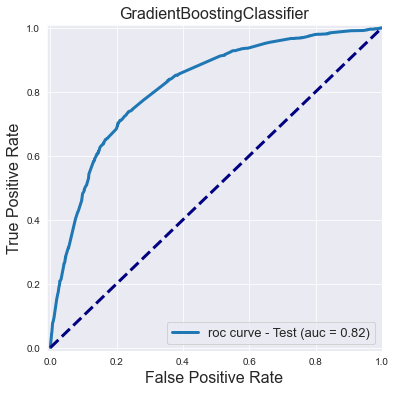



Meilleur cut-off test : 0.484146
Meilleur cut-off train : 0.746887


In [1324]:
fpr_gb, tpr_gb, roc_auc_gb = Model_Perf_Analysis( model = modele[3],X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test)

SMOTE
--------
train score 0.75
--------
test score 0.76
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.88      0.76      0.82      3953
           1       0.52      0.72      0.61      1443

    accuracy                           0.75      5396
   macro avg       0.70      0.74      0.71      5396
weighted avg       0.79      0.75      0.76      5396



Matrice de confusion

[[3000  953]
 [ 400 1043]]
--------
L'AUC est de 0.81
--------
Gini: 0.62
--------
roc curve


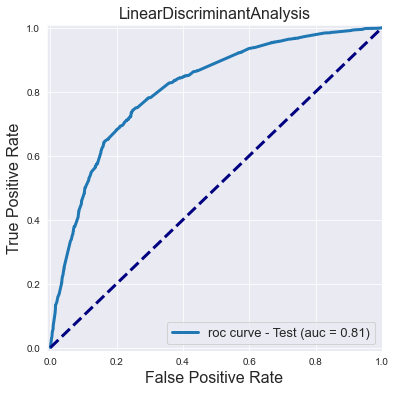



Meilleur cut-off test : 0.623624
Meilleur cut-off train : 0.431705


In [1325]:
fpr_ld, tpr_ld, roc_auc_ld = Model_Perf_Analysis( model = modele[4],X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test)

SMOTE
--------
train score 0.75
--------
test score 0.76
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.88      0.76      0.82      3953
           1       0.53      0.72      0.61      1443

    accuracy                           0.75      5396
   macro avg       0.70      0.74      0.71      5396
weighted avg       0.79      0.75      0.76      5396



Matrice de confusion

[[3008  945]
 [ 398 1045]]
--------
L'AUC est de 0.81
--------
Gini: 0.62
--------
roc curve


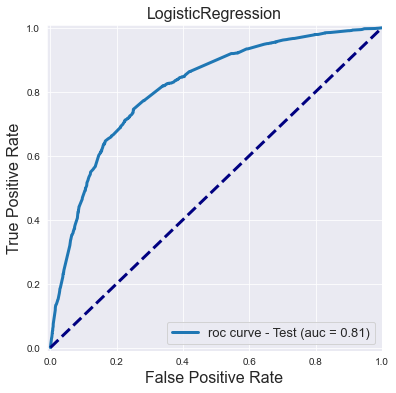



Meilleur cut-off test : 0.615094
Meilleur cut-off train : 0.413501


In [1326]:
fpr_lr, tpr_lr, roc_auc_lr = Model_Perf_Analysis( model = modele[5],X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test)

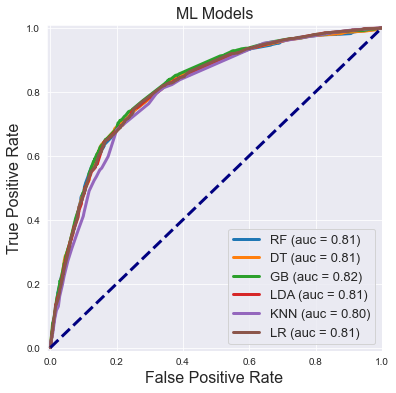

In [1327]:
plt.figure(figsize=(6,6))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_r, tpr_r, lw=3, label='RF (auc = {:0.2f})'.format(roc_auc_r))
plt.plot(fpr_d, tpr_d, lw=3, label='DT (auc = {:0.2f})'.format(roc_auc_d))
plt.plot(fpr_gb, tpr_gb, lw=3, label='GB (auc = {:0.2f})'.format(roc_auc_gb))
plt.plot(fpr_ld, tpr_ld, lw=3, label='LDA (auc = {:0.2f})'.format(roc_auc_ld))
plt.plot(fpr_k, tpr_k, lw=3, label='KNN (auc = {:0.2f})'.format(roc_auc_k))
plt.plot(fpr_lr, tpr_lr, lw=3, label='LR (auc = {:0.2f})'.format(roc_auc_lr))

#plt.plot(fpr_sc, tpr_sc, lw=3, label='SK (auc = {:0.2f})'.format(roc_auc_sc))
#plt.plot(fpr_vc, tpr_vc, lw=3, label='VC (auc = {:0.2f})'.format(roc_auc_vc))
#plt.plot(fpr, tpr, lw=3, label='LR (auc = {:0.2f})'.format(roc_auc))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ML Models', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
#plt.axes().set_aspect('equal')
plt.show()

Construction des Probabilité Homogène de Risque (CHR)
--

In [1328]:
def get_CHR(proba,pred,base,target):
    
    
    """
    list_model = [rfc,knc,dtc,gbc,lda,lr]
    i = 0
    for c in list_model:
        i += 1
        print("modele "+str(i))
        print("-"*12)
        prob = c.predict_proba(X_train)
        pred = c.predict(X_train)
        display(get_CHR(prob,pred,base_model,"default_time"))
        print("\n")
    """
    
    #----------------------------------- construction base pour CHR ------------------------------------#
    
    data = pd.concat([pd.DataFrame(proba),pd.DataFrame(pred)],axis=1)
    data.columns = ["proba_0","proba_1","pred"]
    data[target] = base[target]
    
    #----------------------------- construction base optimal ------------------------------------------#
    data_optimal = data.loc[data["pred"] == 1][["proba_1","pred",target]]
    Bins1 = np.linspace(0,1, num=35)
    data_optimal['bins'] = pd.cut(data_optimal['proba_1'],bins=Bins1,precision=0,labels=False, duplicates='drop')
    data_optimal = data_optimal[['proba_1', 'pred', target, 'bins']]
    data_optimal.columns = ['proba_1', 'pred', target, 'classe']
    
    clean_table = data_optimal.groupby(["classe","default_time"])["classe"].size().to_frame("count")
    clean_table = clean_table.reset_index()

    #--------------------------------------determination des CHR------------------------------------------------#
    somme = [sum(clean_table.loc[clean_table["classe"] == i]["count"]) for i in {c for c in clean_table.classe}]
    defauts = [c for c,i in zip(clean_table["count"],clean_table["default_time"]) if i == 1]
    
    pr = list()
    for som,bad in zip(somme,defauts):
        try:
            pr.append(bad/som)
        except:
            pass
    CHR = pd.DataFrame([])
    cls_ = ["classe "+str(i) for i in range(len(pr))]
    CHR["CLASSE_"] = cls_
    CHR["PROB"] = sorted(pr)
    
    return CHR

In [1329]:
list_model = [rfc,knc,dtc,gbc,lda,lr]
i = 0
for c in list_model:
    i += 1
    print("modele "+str(i)+": "+ str(c))
    print("-"*12)
    prob = c.predict_proba(X_train)
    pred = c.predict(X_train)
    display(get_CHR(prob,pred,base_model,"default_time"))
    print("\n")

modele 1: GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [25, 50, 75, 100],
                         'max_features': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'n_estimators': [5, 15, 25]},
             return_train_score=True, scoring='roc_auc')
------------


,CLASSE_,PROB
0,classe 0,0.032864
1,classe 1,0.046481
2,classe 2,0.050905
3,classe 3,0.057377
4,classe 4,0.123894
5,classe 5,0.133829
6,classe 6,0.151724
7,classe 7,0.167969
8,classe 8,0.177945
9,classe 9,0.237179




modele 2: GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 20, 35]}, return_train_score=True,
             scoring='roc_auc')
------------


,CLASSE_,PROB
0,classe 0,0.043732
1,classe 1,0.100418
2,classe 2,0.111888
3,classe 3,0.120000
4,classe 4,0.159664
5,classe 5,0.167224
6,classe 6,0.175847
7,classe 7,0.268132
8,classe 8,0.307432
9,classe 9,0.423077




modele 3: GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                         'max_features': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]},
             return_train_score=True, scoring='roc_auc')
------------


,CLASSE_,PROB
0,classe 0,0.034483
1,classe 1,0.046025
2,classe 2,0.063584
3,classe 3,0.074468
4,classe 4,0.087948
5,classe 5,0.133178
6,classe 6,0.223077
7,classe 7,0.280000
8,classe 8,0.324022
9,classe 9,0.395604




modele 4: GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [1, 2, 5], 'n_estimators': [5, 15, 25]},
             return_train_score=True, scoring='roc_auc')
------------


,CLASSE_,PROB
0,classe 0,0.157895
1,classe 1,0.188679
2,classe 2,0.221987
3,classe 3,0.222222
4,classe 4,0.237258
5,classe 5,0.245902
6,classe 6,0.253066
7,classe 7,0.258427
8,classe 8,0.262471
9,classe 9,0.270492




modele 5: GridSearchCV(cv=5, estimator=LinearDiscriminantAnalysis(), param_grid={},
             return_train_score=True, scoring='roc_auc')
------------


,CLASSE_,PROB
0,classe 0,0.029595
1,classe 1,0.042781
2,classe 2,0.076121
3,classe 3,0.076642
4,classe 4,0.111511
5,classe 5,0.120000
6,classe 6,0.154762
7,classe 7,0.162996
8,classe 8,0.180556
9,classe 9,0.216867




modele 6: GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')
------------


,CLASSE_,PROB
0,classe 0,0.212121
1,classe 1,0.214953
2,classe 2,0.220238
3,classe 3,0.226562
4,classe 4,0.232877
5,classe 5,0.243304
6,classe 6,0.244353
7,classe 7,0.246154
8,classe 8,0.251613
9,classe 9,0.251916
